In [1]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(harmony))
suppressPackageStartupMessages(library(future))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(trqwe))
suppressPackageStartupMessages(library(unix))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(rmcorr))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(data.table))
source("/rds/general/user/emacdona/projects/covid19-transcriptome/live/sc_rnaseq/scripts/functions/glmm_functions_4.R")

Warning message:
“package ‘readr’ was built under R version 4.1.3”


In [2]:
setwd("/rds/general/user/emacdona/projects/covid19-transcriptome/live/sc_rnaseq/DA/")

In [3]:
################################
#Plot significant results
################################

In [4]:
data<-mcreadRDS("../all_compartments_qc.rds",mc.core=4)

In [5]:
data

An object of class Seurat 
32913 features across 580040 samples within 1 assay 
Active assay: RNA (32913 features, 2000 variable features)
 7 dimensional reductions calculated: pca_RNA, umapBeforeHarmony_RNA, harmony_RNA, umapAfterHarmony_RNA, pca, harmony, umap_harmony_new

In [6]:
"time_from_infection"%in%names(data@meta.data)

[1] FALSE

In [7]:
# calculate days to sampling, days to admission, days to first symptoms, days to discharge from positive swab
tmp<-data@meta.data
tmp$sample_date<-as.Date(tmp$sample_date,format('%d/%m/%Y'))

In [8]:
tmp$date_first_symptoms<-as.Date(tmp$date_first_symptoms,format('%d/%m/%Y'))
tmp$date_positive_swab<-as.Date(tmp$date_positive_swab,format('%d/%m/%Y'))

time_from_first_symptoms<-tmp$sample_date - tmp$date_first_symptoms
time_from_positive_swab<-tmp$sample_date - tmp$date_positive_swab

In [9]:
days_from_first_symptoms<-time_from_first_symptoms
days_from_positive_swab<-time_from_positive_swab

days_from_first_symptoms[is.na(days_from_first_symptoms)]<-0
days_from_positive_swab[is.na(days_from_positive_swab)]<-0

min(days_from_first_symptoms)
min(days_from_positive_swab)

[1] NA 18  2  7 16  9 13 12 14 21 10  5 19  8  6  4 20 11  0 17 47 35 -9 -5 -2
[26] 45  1 15  3 50 -7

[1] NA 15 18  0  4 11 13  9  7  2  5 19 12 14 20  8 17 10  3  6 44 42 47 16 49
[26] 41 54

[1]  0 18  2  7 16  9 13 12 14 21 10  5 19  8  6  4 20 11 17 47 35 -9 -5 -2 45
[26]  1 15  3 50 -7

[1]  0 15 18  4 11 13  9  7  2  5 19 12 14 20  8 17 10  3  6 44 42 47 16 49 41
[26] 54

Time difference of -9 days

Time difference of 0 days

In [10]:
days_from_infection<-c()
for(i in 1:length(days_from_first_symptoms)){
    a<-max(days_from_first_symptoms[i], days_from_positive_swab[i])
    days_from_infection<-c(days_from_infection,a)
}

In [12]:
data@meta.data$time_from_first_symptoms<-days_from_first_symptoms
data@meta.data$time_from_positive_swab<-days_from_positive_swab
data@meta.data$time_from_infection<-days_from_infection

In [14]:
data@meta.data<- data@meta.data %>% mutate(week= case_when(
    !is.na(time_from_infection) & time_from_infection>0 & time_from_infection<=7 ~ "week_1",
    !is.na(time_from_infection) & time_from_infection>7 & time_from_infection<=14 ~ "week_2",
    !is.na(time_from_infection) & time_from_infection>14 | time_from_infection<0 ~ "NA",
    !is.na(time_from_infection) & time_from_infection==0 & case_control=="POSITIVE" ~ "week_1",
    case_control=="NEGATIVE" ~ "control",
))

In [18]:
head(data@meta.data[data@meta.data$time_from_infection==0 & data@meta.data$case_control=="POSITIVE",c("sample_id","case_control","date_positive_swab","date_first_symptoms","time_from_positive_swab","time_from_first_symptoms","time_from_infection","week")])

,sample_id,case_control,date_positive_swab,date_first_symptoms,time_from_positive_swab,time_from_first_symptoms,time_from_infection,week
,<chr>,<chr>,<chr>,<chr>,<drtn>,<drtn>,<dbl>,<chr>
UK-CIC10689760+UK-CIC10690048_AAACCTGTCATGTAGC-1,C34_1404,POSITIVE,14/04/2020,14/04/2020,0 days,0 days,0,week_1
UK-CIC10689760+UK-CIC10690048_AAACGGGTCATCTGCC-1,C34_1404,POSITIVE,14/04/2020,14/04/2020,0 days,0 days,0,week_1
UK-CIC10689760+UK-CIC10690048_AAAGATGAGCCAGTAG-1,C34_1404,POSITIVE,14/04/2020,14/04/2020,0 days,0 days,0,week_1
UK-CIC10689760+UK-CIC10690048_AAAGATGAGCTGCCCA-1,C34_1404,POSITIVE,14/04/2020,14/04/2020,0 days,0 days,0,week_1
UK-CIC10689760+UK-CIC10690048_AAAGATGGTTGGGACA-1,C34_1404,POSITIVE,14/04/2020,14/04/2020,0 days,0 days,0,week_1
UK-CIC10689760+UK-CIC10690048_AAAGCAAAGATCCGAG-1,C34_1404,POSITIVE,14/04/2020,14/04/2020,0 days,0 days,0,week_1


In [19]:
data@meta.data<- data@meta.data %>% mutate(week10= case_when(
    !is.na(time_from_infection) & time_from_infection>0 & time_from_infection<=10 ~ "week_1",
    !is.na(time_from_infection) & time_from_infection>10 & time_from_infection<=20 ~ "week_2",
    !is.na(time_from_infection) & time_from_infection>20 | time_from_infection<0 ~ "NA",
    time_from_infection==0 & case_control=="POSITIVE" ~ "week_1",
    case_control=="NEGATIVE" ~ "control",
))

In [21]:
head(data@meta.data[data@meta.data$week=="NA",])

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,nCount_ADT_raw,nFeature_ADT_raw,nCount_RNA_raw,nFeature_RNA_raw,soupxOnAdt,⋯,new_ethnicity,corrected_ethnicity,PC1_nonafricanVsAfrican,PC2_asianVsEuropean,percent.mt,time_from_first_symptoms,time_from_positive_swab,time_from_infection,week,week10
,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<drtn>,<drtn>,<dbl>,<chr>,<chr>
UK-CIC10689738+UK-CIC10690026_AAACCTGGTTGAACTC-1,UK-CIC10689738+UK-CIC10690026,2938.627,1400,1262.7719,84,2784,132,2984,1407,Pass,⋯,asian,Asian,6.961038,12.20309,1.429801,18 days,15 days,18,NA,week_2
UK-CIC10689738+UK-CIC10690026_AAACGGGAGATAGCAT-1,UK-CIC10689738+UK-CIC10690026,2288.354,1127,1492.6226,65,2887,133,2311,1129,Pass,⋯,asian,Asian,6.961038,12.20309,3.415107,18 days,15 days,18,NA,week_2
UK-CIC10689738+UK-CIC10690026_AAACGGGCAAGCGTAG-1,UK-CIC10689738+UK-CIC10690026,3392.694,1475,1907.7365,55,3771,132,3448,1479,Pass,⋯,asian,Asian,6.961038,12.20309,2.119016,18 days,15 days,18,NA,week_2
UK-CIC10689738+UK-CIC10690026_AAACGGGCATTACCTT-1,UK-CIC10689738+UK-CIC10690026,5367.044,2109,1797.2456,47,3274,129,5443,2114,Pass,⋯,asian,Asian,6.961038,12.20309,2.848988,18 days,15 days,18,NA,week_2
UK-CIC10689738+UK-CIC10690026_AAAGATGCATCGGTTA-1,UK-CIC10689738+UK-CIC10690026,3272.977,1208,746.9884,78,1679,132,3318,1213,Pass,⋯,asian,Asian,6.961038,12.20309,1.705697,18 days,15 days,18,NA,week_2
UK-CIC10689738+UK-CIC10690026_AAAGCAAGTCTCCATC-1,UK-CIC10689738+UK-CIC10690026,2643.518,1264,1057.2950,72,2218,133,2672,1266,Pass,⋯,asian,Asian,6.961038,12.20309,2.382110,18 days,15 days,18,NA,week_2


In [22]:
head(data@meta.data[data@meta.data$week10=="NA",])

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,nCount_ADT_raw,nFeature_ADT_raw,nCount_RNA_raw,nFeature_RNA_raw,soupxOnAdt,⋯,new_ethnicity,corrected_ethnicity,PC1_nonafricanVsAfrican,PC2_asianVsEuropean,percent.mt,time_from_first_symptoms,time_from_positive_swab,time_from_infection,week,week10
,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<drtn>,<drtn>,<dbl>,<chr>,<chr>
UK-CIC10689748+UK-CIC10690036_AAACCTGAGGTAAACT-1,UK-CIC10689748+UK-CIC10690036,4628.647,1653,2648.519,41,3991,124,4699,1659,Pass,⋯,other,Asian,3.023012,9.463019,2.749940,21 days,18 days,21,NA,NA
UK-CIC10689748+UK-CIC10690036_AAACCTGGTTGTCGCG-1,UK-CIC10689748+UK-CIC10690036,3852.939,1552,2091.902,83,3517,132,3931,1564,Pass,⋯,other,Asian,3.023012,9.463019,2.040409,21 days,18 days,21,NA,NA
UK-CIC10689748+UK-CIC10690036_AAACCTGTCGTGACAT-1,UK-CIC10689748+UK-CIC10690036,2691.520,955,2464.270,50,3526,127,2754,961,Pass,⋯,other,Asian,3.023012,9.463019,2.276409,21 days,18 days,21,NA,NA
UK-CIC10689748+UK-CIC10690036_AAACGGGCAAGGCTCC-1,UK-CIC10689748+UK-CIC10690036,5597.618,1730,4418.537,46,6432,125,5669,1735,Pass,⋯,other,Asian,3.023012,9.463019,1.912616,21 days,18 days,21,NA,NA
UK-CIC10689748+UK-CIC10690036_AAACGGGGTCTCATCC-1,UK-CIC10689748+UK-CIC10690036,4687.806,1558,3347.531,42,4934,132,4753,1564,Pass,⋯,other,Asian,3.023012,9.463019,1.671517,21 days,18 days,21,NA,NA
UK-CIC10689748+UK-CIC10690036_AAACGGGGTGGCGAAT-1,UK-CIC10689748+UK-CIC10690036,2733.074,1082,2525.796,47,3678,120,2769,1087,Pass,⋯,other,Asian,3.023012,9.463019,3.293504,21 days,18 days,21,NA,NA


In [23]:
table(data@meta.data$week,useNA="always")
table(data@meta.data$week10,useNA="always")


control      NA  week_1  week_2    <NA> 
 159305  118562  133888  168285       0 


control      NA  week_1  week_2    <NA> 
 159305   43759  180610  196366       0 

In [24]:
data@meta.data[data@meta.data$week=="NA",]<-NA

In [26]:
table(data@meta.data$week,useNA="always")
table(data@meta.data$week10,useNA="always")


control  week_1  week_2    <NA> 
 159305  133888  168285  118562 


control  week_1  week_2    <NA> 
 159305  180610  121563  118562 

In [28]:
data_new<-data

In [29]:
data1<-data_new

In [30]:
abundances<-table(data1@meta.data$level_2,data1@meta.data$sample_id)
abundances<-unclass(abundances)
data<-as.SingleCellExperiment(data1)
data

sce<-data

class: SingleCellExperiment 
dim: 32913 580040 
metadata(0):
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(0):
colnames(580040): UK-CIC10689738+UK-CIC10690026_AAACCTGAGGCAATTA-1
  UK-CIC10689738+UK-CIC10690026_AAACCTGCAAGCCGCT-1 ...
  UK-CIC10690384+UK-CIC10690576_TTTGGTTTCTTAACCT-1
  UK-CIC10690384+UK-CIC10690576_TTTGTCAGTACAAGTA-1
colData names(178): orig.ident nCount_RNA ... week10 ident
reducedDimNames(7): PCA_RNA UMAPBEFOREHARMONY_RNA ... HARMONY
  UMAP_HARMONY_NEW
mainExpName: RNA
altExpNames(0):

In [31]:
min_cells<-10

In [32]:
sce$individual_id<-factor(sce$individual_id)
sce$sample_id<-factor(sce$sample_id)
sce$ethnicity<-factor(sce$ethnicity)
sce$sex<-factor(sce$sex)
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age

In [33]:
# Remove samples with less than 10 cells
nCells <- table(sce$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
rm_ids<-c("C116","C139")
sce1 <- sce[, !sce$sample_id %in% rmSamples & !sce$individual_id %in% rm_ids]

In [34]:
# Summarize Counts
smrzd <- aggregateAcrossCells(sce1, id = as.character(colData(sce1)[, c("sample_id")]))

In [35]:
dim(colData(smrzd))
dim(abundances)

[1] 146 185

[1]  35 147

In [38]:
abundances<-abundances[,colnames(abundances)%in%rownames(colData(smrzd))]

[1] "C168_260121"

In [40]:
tmp<-data.frame(t(abundances))
head(tmp)

,ASDC,B_ASC_dividing,B_ASC_IgA,B_ASC_IgG,B_ASC_IgM,B_ASC_other,B_CD11c,B_naive,B_non.switched_mem,B_switched_mem,⋯,T.CD4.CTL,T.CD4.cycling,T.CD4.Helper,T.CD4.Naive,T.CD8.CTL,T.CD8.EMRA,T.CD8.Mem,T.CD8.Naive,T.g.d,T.reg
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
C101_060121,0,0,0,0,0,0,2,7,0,3,⋯,24,0,16,4,169,0,6,0,1,0
C101_110121,0,0,3,3,0,0,2,6,2,12,⋯,17,0,0,2,129,0,0,3,0,0
C101_130121,1,2,1,5,1,0,13,32,17,34,⋯,107,0,36,12,451,0,15,4,3,0
C103_2204,4,18,59,9,5,0,6,276,26,164,⋯,255,16,1610,567,834,5,235,115,160,236
C104_2204,8,3,39,4,2,2,39,217,38,96,⋯,662,6,864,298,911,0,321,61,11,120
C106_2204,7,0,13,6,1,1,1,266,20,30,⋯,159,1,1247,1759,1489,0,276,338,29,249


In [41]:
tmp$sample_id<-rownames(tmp)

In [42]:
head(tmp)

,ASDC,B_ASC_dividing,B_ASC_IgA,B_ASC_IgG,B_ASC_IgM,B_ASC_other,B_CD11c,B_naive,B_non.switched_mem,B_switched_mem,⋯,T.CD4.cycling,T.CD4.Helper,T.CD4.Naive,T.CD8.CTL,T.CD8.EMRA,T.CD8.Mem,T.CD8.Naive,T.g.d,T.reg,sample_id
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
C101_060121,0,0,0,0,0,0,2,7,0,3,⋯,0,16,4,169,0,6,0,1,0,C101_060121
C101_110121,0,0,3,3,0,0,2,6,2,12,⋯,0,0,2,129,0,0,3,0,0,C101_110121
C101_130121,1,2,1,5,1,0,13,32,17,34,⋯,0,36,12,451,0,15,4,3,0,C101_130121
C103_2204,4,18,59,9,5,0,6,276,26,164,⋯,16,1610,567,834,5,235,115,160,236,C103_2204
C104_2204,8,3,39,4,2,2,39,217,38,96,⋯,6,864,298,911,0,321,61,11,120,C104_2204
C106_2204,7,0,13,6,1,1,1,266,20,30,⋯,1,1247,1759,1489,0,276,338,29,249,C106_2204


In [44]:
tmp_long<-melt(tmp)

Using sample_id as id variables



In [45]:
head(tmp_long)
names(tmp_long)<-c("sample_id","cell_type","abundance")

,sample_id,variable,value
,<chr>,<fct>,<int>
1,C101_060121,ASDC,0
2,C101_110121,ASDC,0
3,C101_130121,ASDC,1
4,C103_2204,ASDC,4
5,C104_2204,ASDC,8
6,C106_2204,ASDC,7


In [46]:
new<-merge(tmp,colData(smrzd),by="sample_id",all.x=TRUE)
dim(new)

[1] 146 220

In [47]:
unique(tmp_long$cell_type)

[1] ASDC               B_ASC_dividing     B_ASC_IgA          B_ASC_IgG         
 [5] B_ASC_IgM          B_ASC_other        B_CD11c            B_naive           
 [9] B_non.switched_mem B_switched_mem     CD14mono           CD16mono          
[13] DC1                DC2                DC3                HSPC              
[17] ILC                Int.mono           MAIT               NK                
[21] NK.CD56.bright     NKT                pDC                Platelet          
[25] RBC                T.CD4.CTL          T.CD4.cycling      T.CD4.Helper      
[29] T.CD4.Naive        T.CD8.CTL          T.CD8.EMRA         T.CD8.Mem         
[33] T.CD8.Naive        T.g.d              T.reg             
35 Levels: ASDC B_ASC_dividing B_ASC_IgA B_ASC_IgG B_ASC_IgM ... T.reg

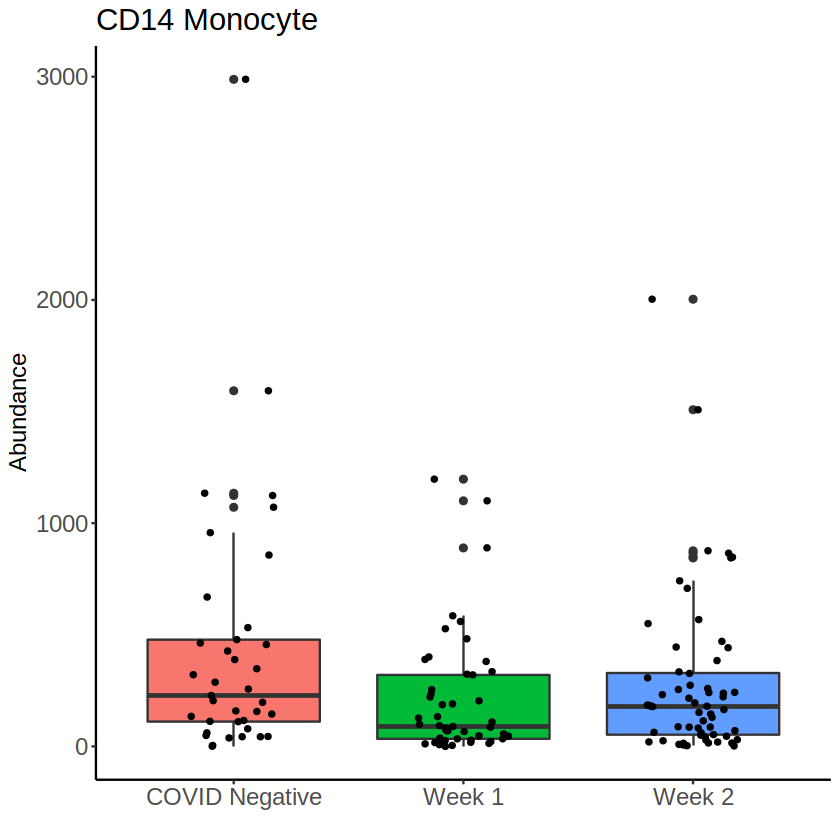

In [75]:
ggplot(data.frame(new),aes(x=week,y=CD14mono,fill=week))+
    geom_boxplot()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("CD14 Monocyte")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_CD14mono.pdf",width=5,height=5)

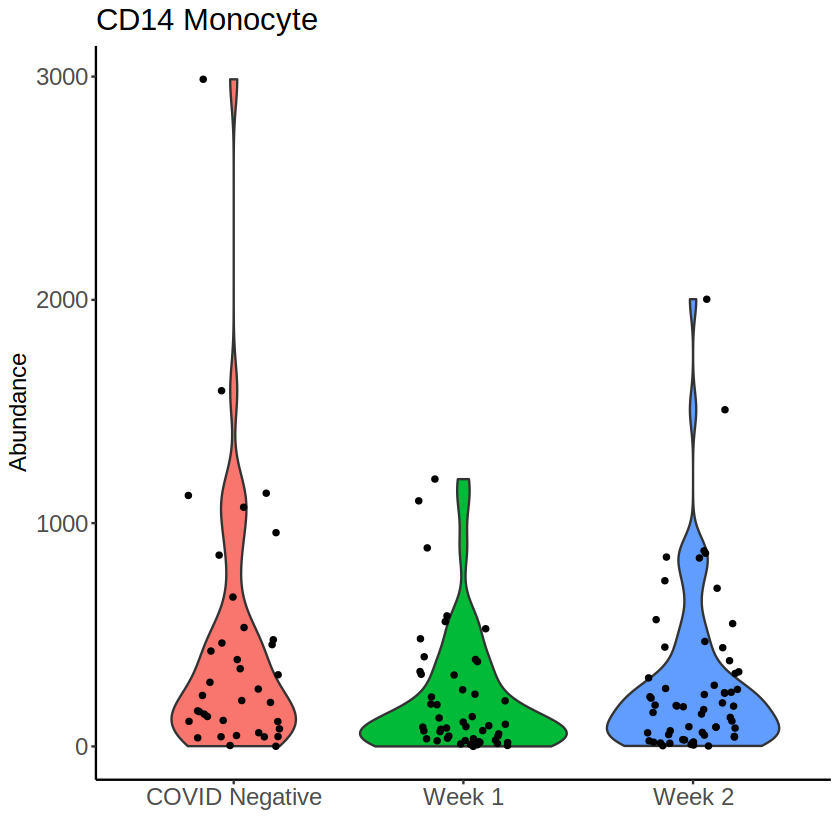

In [76]:
ggplot(data.frame(new),aes(x=week,y=CD14mono,fill=week))+
    geom_violin()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("CD14 Monocyte")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_violin_CD14mono.pdf",width=5,height=5)

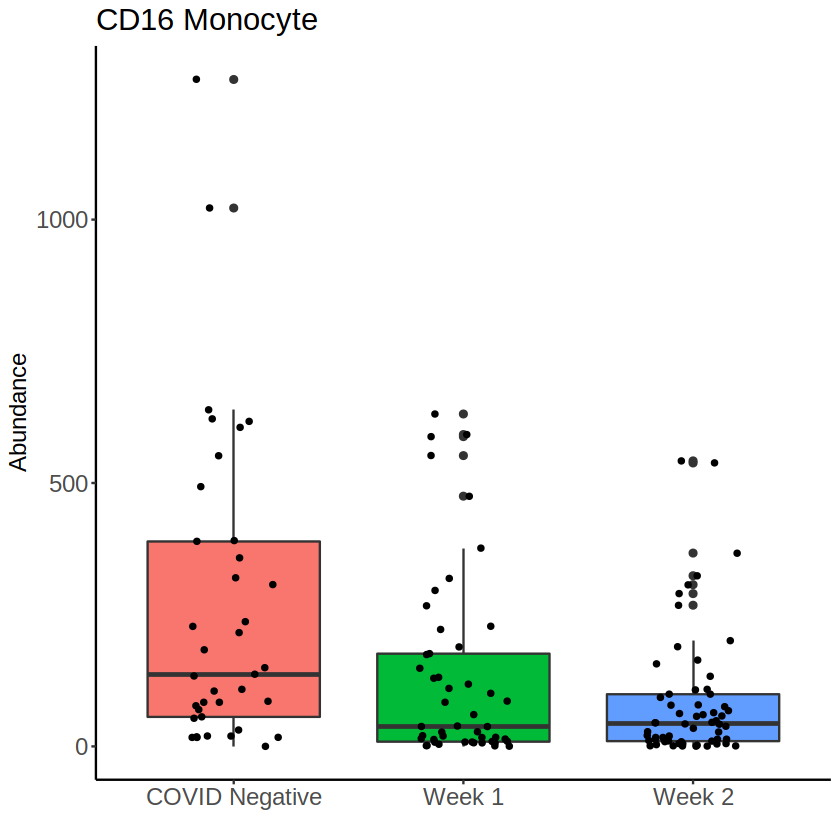

In [77]:
ggplot(data.frame(new),aes(x=week,y=CD16mono,fill=week))+
    geom_boxplot()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("CD16 Monocyte")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_CD16mono.pdf",width=5,height=5)

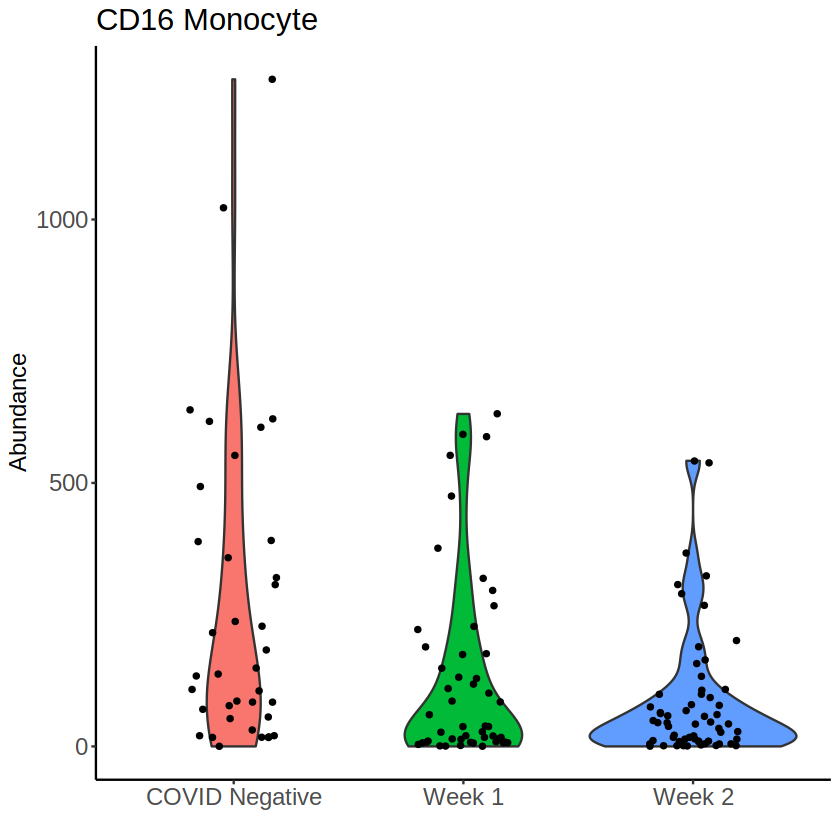

In [78]:
ggplot(data.frame(new),aes(x=week,y=CD16mono,fill=week))+
    geom_violin()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("CD16 Monocyte")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_violin_CD16mono.pdf",width=5,height=5)

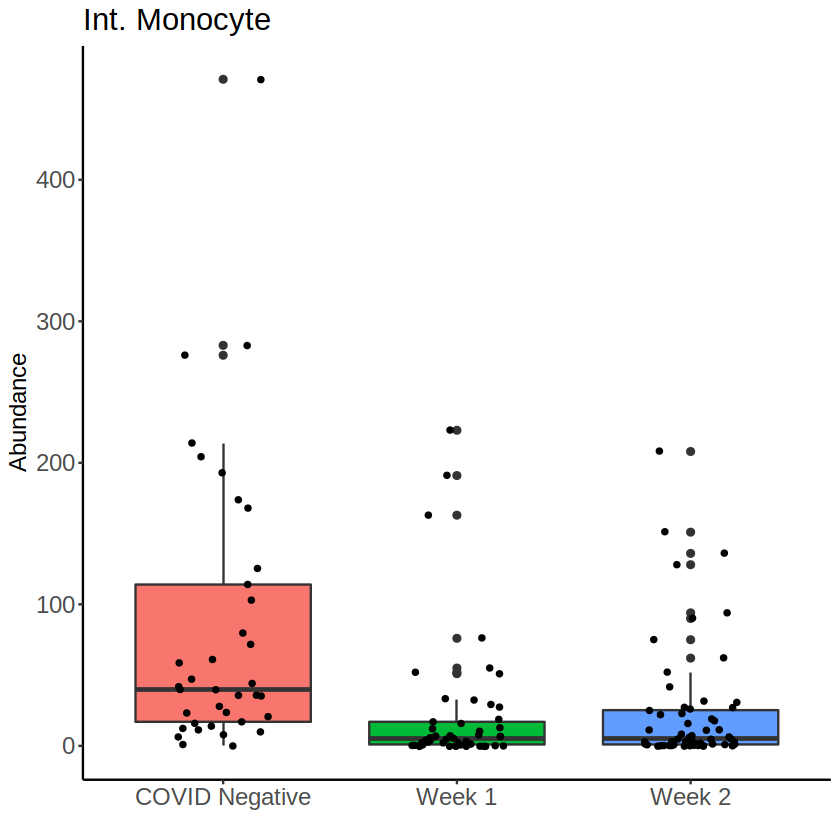

In [79]:
ggplot(data.frame(new),aes(x=week,y=Int.mono,fill=week))+
    geom_boxplot()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("Int. Monocyte")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_Int.mono.pdf",width=5,height=5)

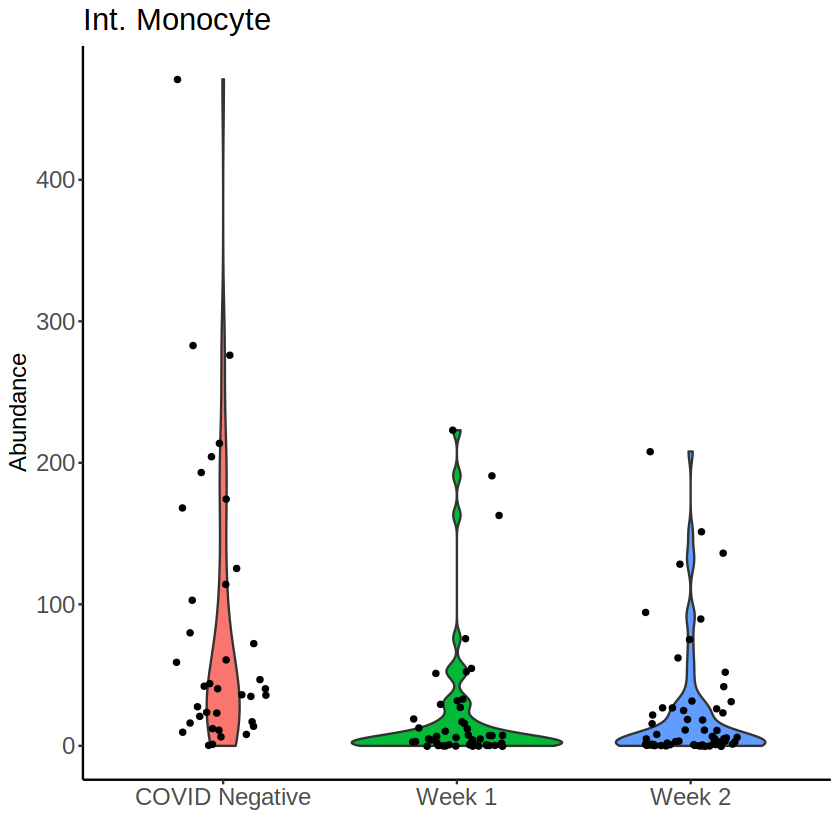

In [80]:
ggplot(data.frame(new),aes(x=week,y=Int.mono,fill=week))+
    geom_violin()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("Int. Monocyte")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_violin_Int.mono.pdf",width=5,height=5)

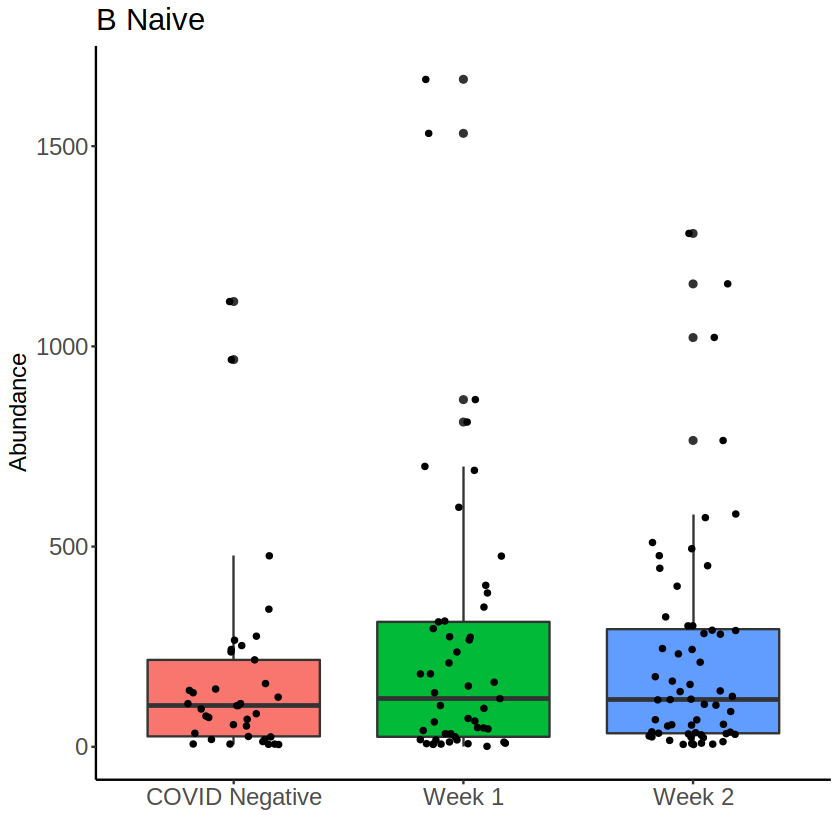

In [81]:
ggplot(data.frame(new),aes(x=week,y=B_naive,fill=week))+
    geom_boxplot()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("B Naive")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_B_naive.pdf",width=5,height=5)

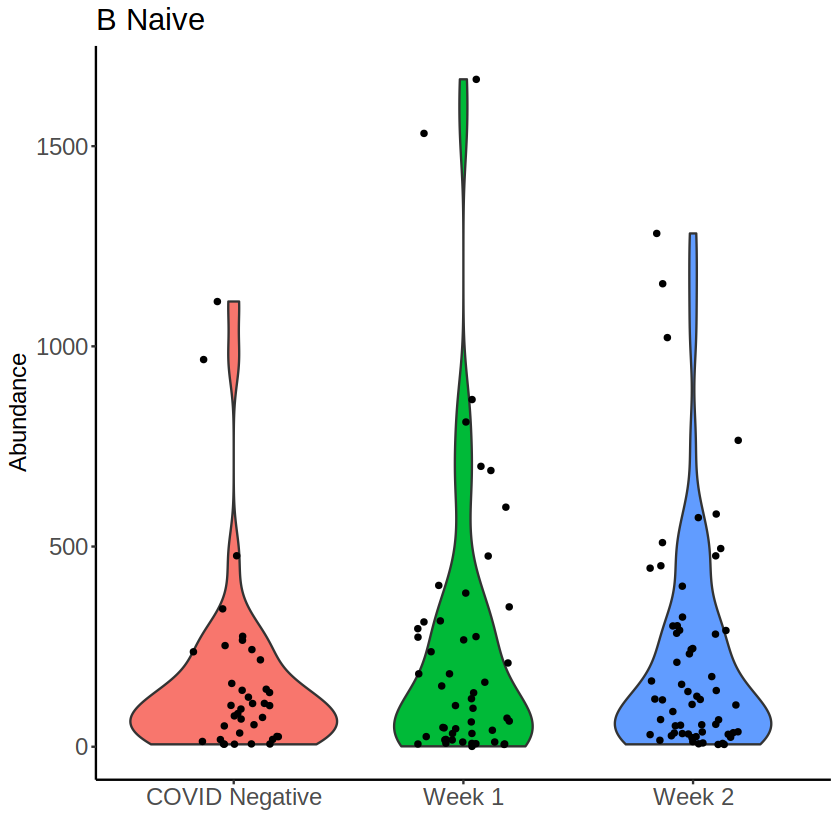

In [82]:
ggplot(data.frame(new),aes(x=week,y=B_naive,fill=week))+
    geom_violin()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("B Naive")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_violin_B_naive.pdf",width=5,height=5)

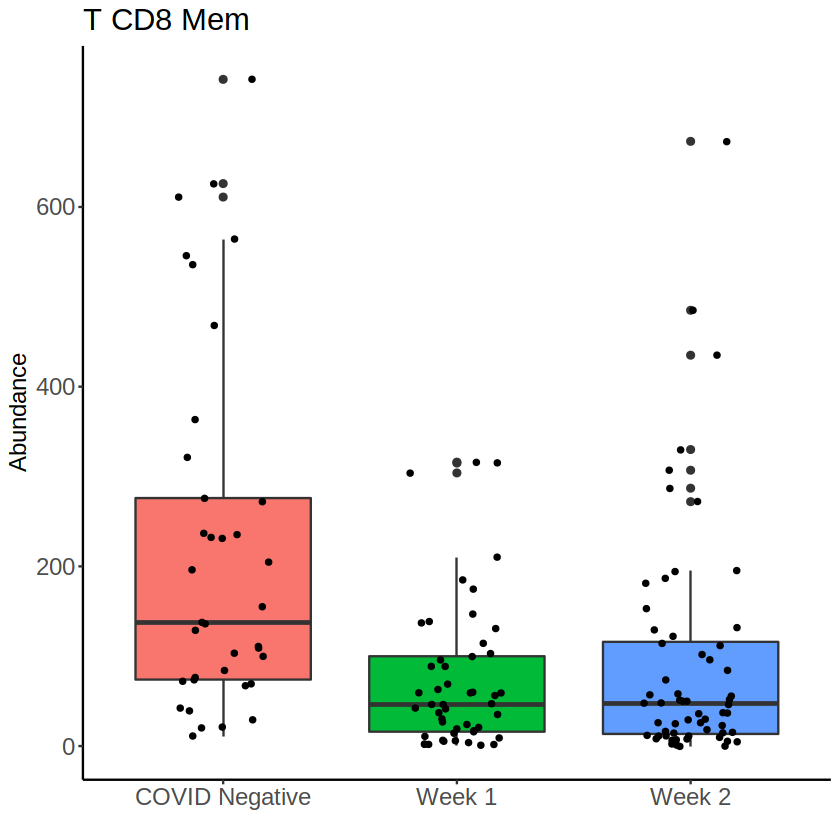

In [83]:
ggplot(data.frame(new),aes(x=week,y=T.CD8.Mem,fill=week))+
    geom_boxplot()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("T CD8 Mem")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_T.CD8.Mem.pdf",width=5,height=5)

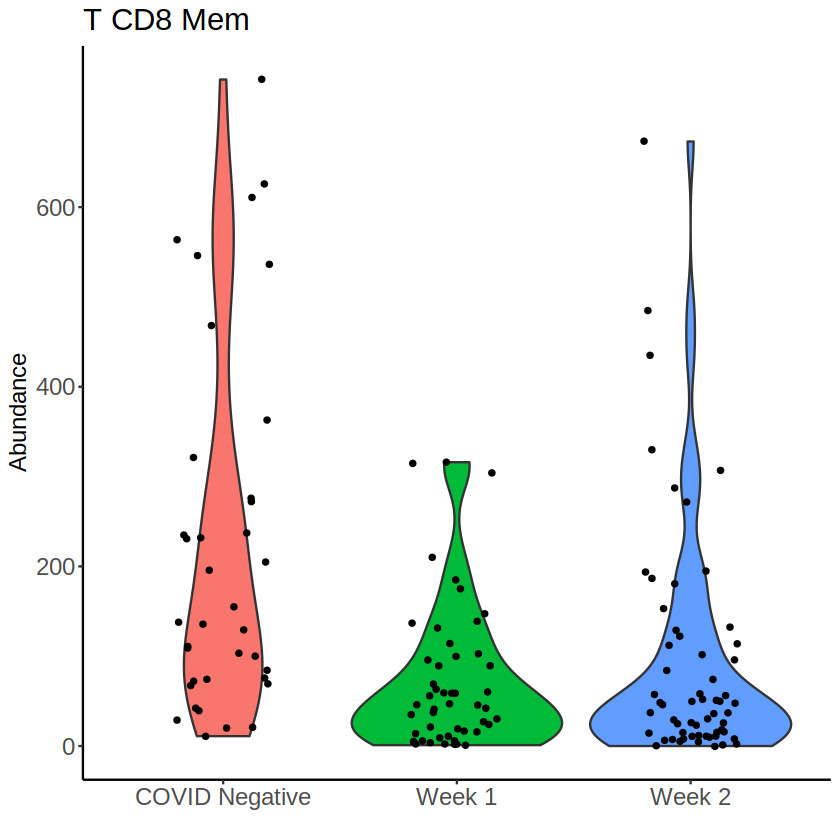

In [84]:
ggplot(data.frame(new),aes(x=week,y=T.CD8.Mem,fill=week))+
    geom_violin()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("T CD8 Mem")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_violin_T.CD8.Mem.pdf",width=5,height=5)

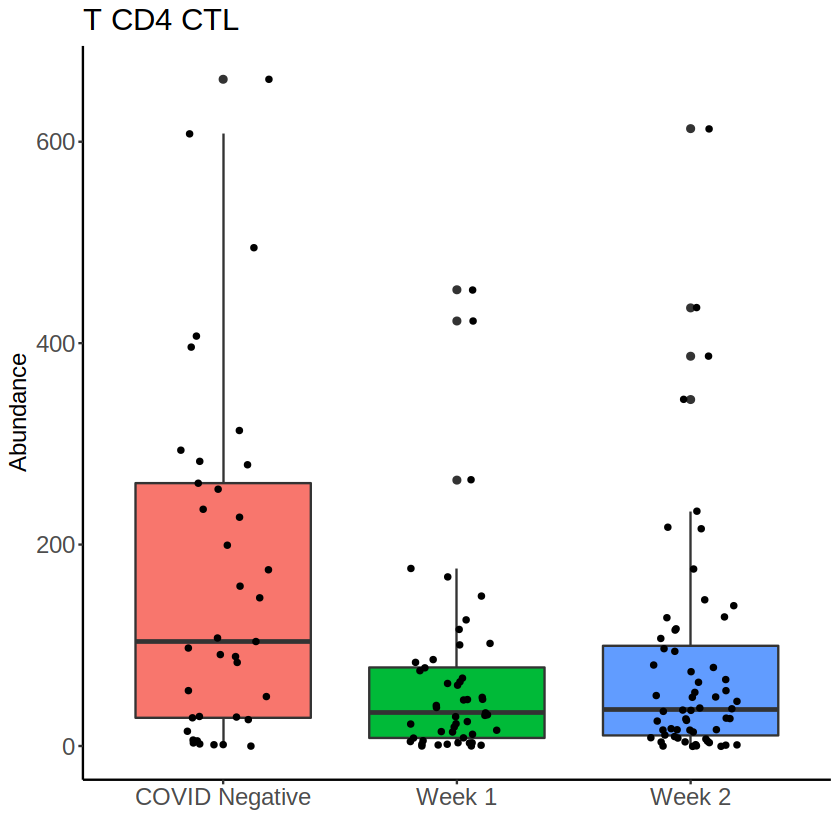

In [85]:
ggplot(data.frame(new),aes(x=week,y=T.CD4.CTL,fill=week))+
    geom_boxplot()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("T CD4 CTL")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_T.CD4.CTL.pdf",width=5,height=5)

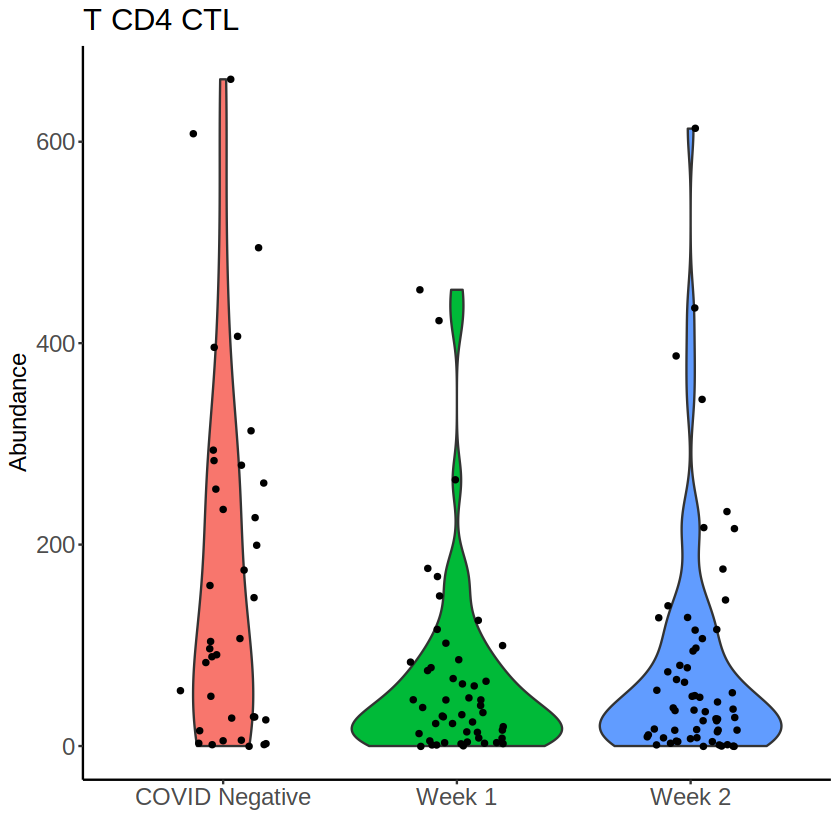

In [86]:
ggplot(data.frame(new),aes(x=week,y=T.CD4.CTL,fill=week))+
    geom_violin()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("T CD4 CTL")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_violin_T.CD4.CTL.pdf",width=5,height=5)

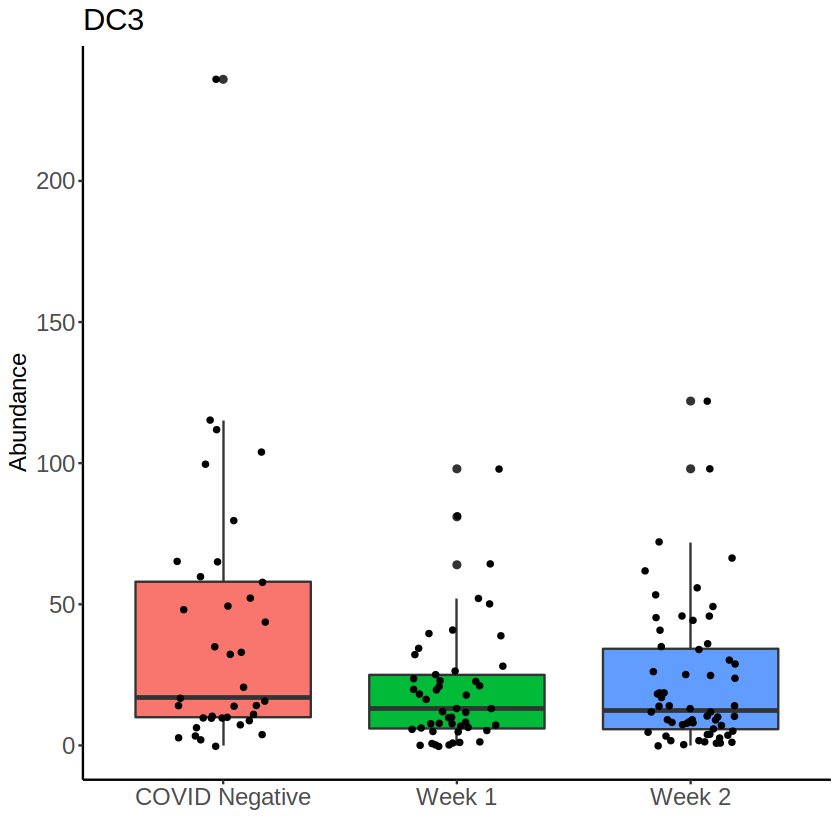

In [87]:
ggplot(data.frame(new),aes(x=week,y=DC3,fill=week))+
    geom_boxplot()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("DC3")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_DC3.pdf",width=5,height=5)

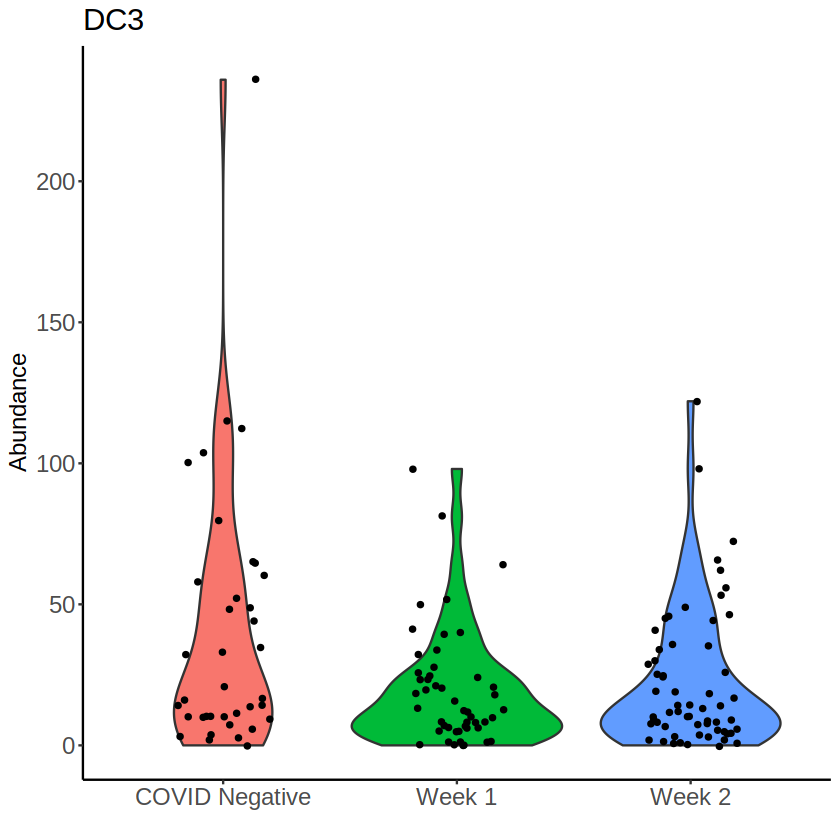

In [88]:
ggplot(data.frame(new),aes(x=week,y=DC3,fill=week))+
    geom_violin()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("DC3")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_violin_DC3.pdf",width=5,height=5)

In [90]:
####################
# Level 1
####################

In [91]:
data1<-data_new

In [92]:
abundances<-table(data1@meta.data$level_1,data1@meta.data$sample_id)
abundances<-unclass(abundances)
data<-as.SingleCellExperiment(data1)
data

class: SingleCellExperiment 
dim: 32913 580040 
metadata(0):
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(0):
colnames(580040): UK-CIC10689738+UK-CIC10690026_AAACCTGAGGCAATTA-1
  UK-CIC10689738+UK-CIC10690026_AAACCTGCAAGCCGCT-1 ...
  UK-CIC10690384+UK-CIC10690576_TTTGGTTTCTTAACCT-1
  UK-CIC10690384+UK-CIC10690576_TTTGTCAGTACAAGTA-1
colData names(178): orig.ident nCount_RNA ... week10 ident
reducedDimNames(7): PCA_RNA UMAPBEFOREHARMONY_RNA ... HARMONY
  UMAP_HARMONY_NEW
mainExpName: RNA
altExpNames(0):

In [93]:
sce<-data
min_cells<-10

sce$individual_id<-factor(sce$individual_id)
sce$sample_id<-factor(sce$sample_id)
sce$ethnicity<-factor(sce$ethnicity)
sce$sex<-factor(sce$sex)
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age

In [94]:
# Remove samples with less than 10 cells
nCells <- table(sce$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
rm_ids<-c("C116","C139")
sce1 <- sce[, !sce$sample_id %in% rmSamples & !sce$individual_id %in% rm_ids]

# Summarize Counts
smrzd <- aggregateAcrossCells(sce1, id = as.character(colData(sce1)[, c("sample_id")]))

dim(colData(smrzd))
dim(abundances)

[1] 146 185

[1]  13 147

In [95]:
colnames(abundances)[!colnames(abundances)%in%rownames(colData(smrzd))]
abundances<-abundances[,colnames(abundances)%in%rownames(colData(smrzd))]

[1] "C168_260121"

In [96]:
head(t(abundances))
tmp<-data.frame(t(abundances))
head(tmp)
tmp$sample_id<-rownames(tmp)
head(tmp)
#test with long
tmp_long<-melt(tmp)

,B,B_ASC,DC,HSPC,MAIT,monocyte,NK,Platelet,RBC,T CD4+,T CD8+,T g/d,T reg
C101_060121,12,0,15,3,0,52,36,8,1,44,175,1,0
C101_110121,22,6,71,4,1,259,40,10,3,19,132,0,0
C101_130121,98,7,118,22,0,946,133,70,14,155,470,3,0
C103_2204,490,73,215,15,82,2429,1395,12,1,2448,1189,160,236
C104_2204,393,47,720,20,9,4725,2161,20,35,1830,1293,11,120
C106_2204,317,21,408,23,12,1816,1071,8,8,3166,2103,29,249


,B,B_ASC,DC,HSPC,MAIT,monocyte,NK,Platelet,RBC,T.CD4.,T.CD8.,T.g.d,T.reg
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
C101_060121,12,0,15,3,0,52,36,8,1,44,175,1,0
C101_110121,22,6,71,4,1,259,40,10,3,19,132,0,0
C101_130121,98,7,118,22,0,946,133,70,14,155,470,3,0
C103_2204,490,73,215,15,82,2429,1395,12,1,2448,1189,160,236
C104_2204,393,47,720,20,9,4725,2161,20,35,1830,1293,11,120
C106_2204,317,21,408,23,12,1816,1071,8,8,3166,2103,29,249


,B,B_ASC,DC,HSPC,MAIT,monocyte,NK,Platelet,RBC,T.CD4.,T.CD8.,T.g.d,T.reg,sample_id
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
C101_060121,12,0,15,3,0,52,36,8,1,44,175,1,0,C101_060121
C101_110121,22,6,71,4,1,259,40,10,3,19,132,0,0,C101_110121
C101_130121,98,7,118,22,0,946,133,70,14,155,470,3,0,C101_130121
C103_2204,490,73,215,15,82,2429,1395,12,1,2448,1189,160,236,C103_2204
C104_2204,393,47,720,20,9,4725,2161,20,35,1830,1293,11,120,C104_2204
C106_2204,317,21,408,23,12,1816,1071,8,8,3166,2103,29,249,C106_2204


Using sample_id as id variables



In [97]:
head(tmp_long)
names(tmp_long)<-c("sample_id","cell_type","abundance")

,sample_id,variable,value
,<chr>,<fct>,<int>
1,C101_060121,B,12
2,C101_110121,B,22
3,C101_130121,B,98
4,C103_2204,B,490
5,C104_2204,B,393
6,C106_2204,B,317


In [98]:
new<-merge(tmp,colData(smrzd),by="sample_id",all.x=TRUE)
dim(new)
unique(tmp_long$cell_type)

[1] 146 198

[1] B        B_ASC    DC       HSPC     MAIT     monocyte NK       Platelet
 [9] RBC      T.CD4.   T.CD8.   T.g.d    T.reg   
13 Levels: B B_ASC DC HSPC MAIT monocyte NK Platelet RBC T.CD4. ... T.reg

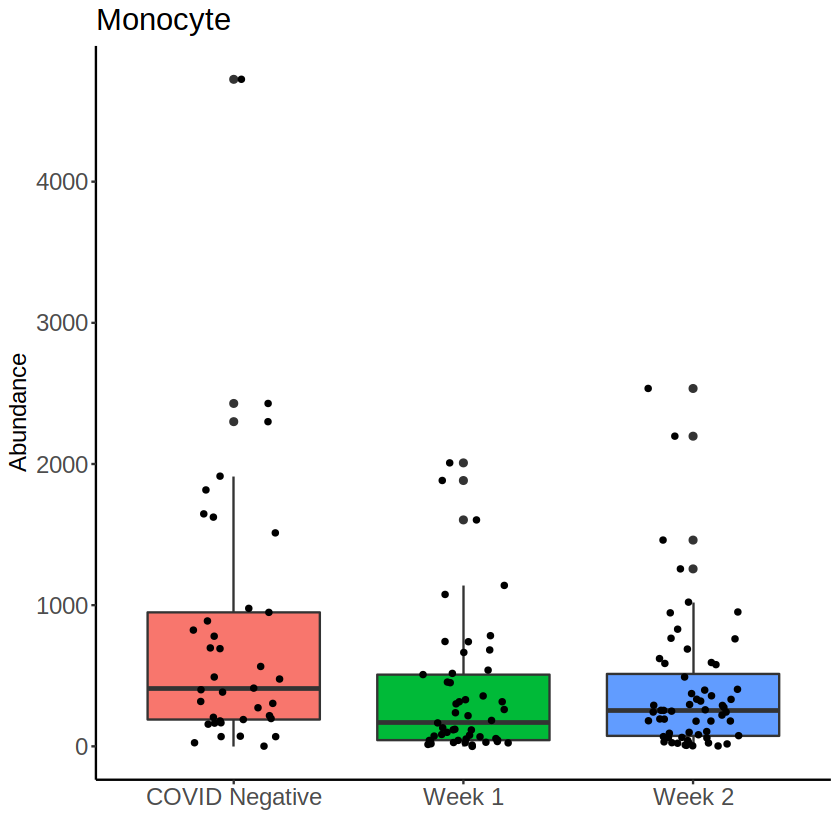

In [99]:
ggplot(data.frame(new),aes(x=week,y=monocyte,fill=week))+
    geom_boxplot()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("Monocyte")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_monocyte.pdf",width=5,height=5)



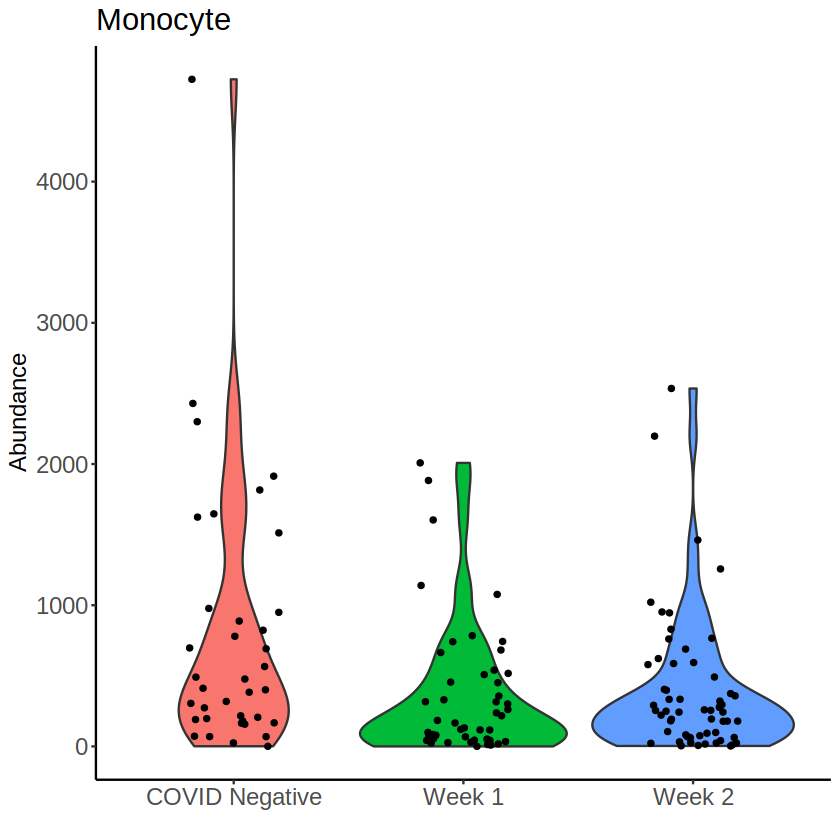

In [100]:


ggplot(data.frame(new),aes(x=week,y=monocyte,fill=week))+
    geom_violin()+
    geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_x_discrete(labels=c("control" = "COVID Negative", "week_1" = "Week 1","week_2" = "Week 2"))+
    #facet_wrap(~cell_type)+
    ylab("Abundance")+
    xlab("")+
    ggtitle("Monocyte")+
    theme_classic()+
    theme(plot.title = element_text(size=18),
        legend.position="none",
         axis.text= element_text(size=14),
         axis.title.y= element_text(size=14))
ggsave("control_week1_violin_monocyte.pdf",width=5,height=5)